In [3]:
from standardInclude import *

Welcome to JupyROOT 6.12/06
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


In [4]:
distributions = [ ['nominal', 30445, 'ding'], #name, fr run, root file
                  #['half_high', 30464, 'highMom_half_hists.root'],
                  #['half_low', 30466, 'lowMom_half_hists.root'],
                  #['third_high', 30468, 'highMom_third_hists.root'],
                  #['third_low', 30472, 'lowMom_third_hists.root'],
                  #['fifth_high', 30475, 'results_fifthCtag_highMomentum.root'],
                  #['fifth_low', 30479, 'results_fifthCtag_lowMomentum.root']
                  ['fifth_high', 30475, 'highMom_fifth_hists.root'],
                  ['fifth_low', 30479, 'lowMom_fifth_hists.root'],
                  ['fifth_middle', 30483, 'midMom_fifth_hists.root']
                ]

nDists = len(distributions)

### Fast rotation distributions
---

In [5]:
frdists = []
for name, run, hist_file in distributions:
    f = r.TFile("./fastRotation/CornellFourier_run"+str(run)+"_results.root")
    #f.ls()
    gri = f.Get("rad")
    frdists.append(gri.Clone("rad_"+str(name)))
print(frdists)
    

[<ROOT.TGraph object ("rad_nominal") at 0x7fffcfb517a0>, <ROOT.TGraph object ("rad_fifth_high") at 0x7fffcf9a4930>, <ROOT.TGraph object ("rad_fifth_low") at 0x7fffcfb426f0>, <ROOT.TGraph object ("rad_fifth_middle") at 0x7fffcf974f70>]


In [6]:
colors = [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

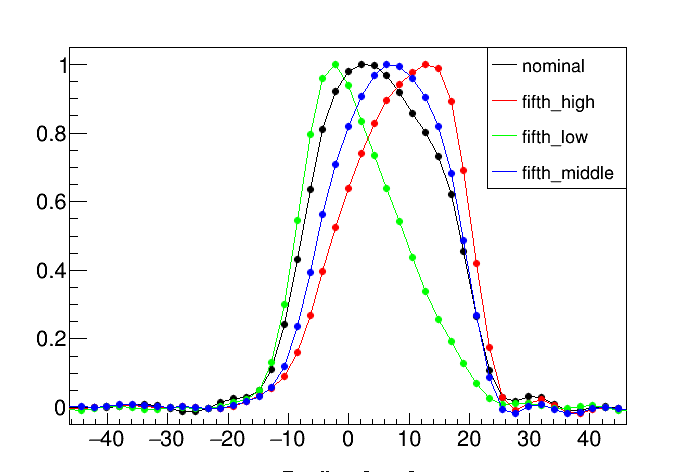

In [7]:
c = r.TCanvas()
leg = r.TLegend(0.7,0.6,0.9,0.9)

for i in range(nDists):
    if(i > 0):
        frdists[i].Draw("pl SAME")
    else:
        frdists[i].Draw("apl")
    frdists[i].SetLineColor(colors[i])
    frdists[i].SetMarkerColor(colors[i])
    leg.AddEntry(frdists[i], distributions[i][0],"l")
leg.Draw("SAME")
c.Draw()

---
### Now lets get the muon loss functions
---

In [32]:
lossHistograms = []

for name, run, hist_file in distributions:
    f = r.TFile("./muonLoss/"+hist_file)
    #f.ls()
    
    #h_sing = f.Get("CoincidenceFinderLM/clusterTimecaloNumsingle_").Clone("h_sing")
    h_sing = f.Get("nearlineCTag").Clone("h_sing")
    h_sing.SetDirectory(0)
    h_tripi = f.Get("clusterTimecaloNumtriple_").Clone("h_tripi")
    h_tripi.SetDirectory(0)
    
    h_trip = r.TH3D()
    h_tripi.Copy(h_trip)
    h_trip.SetDirectory(0)
    
    #print(h_sing.GetEntries(), h_sing.Integral())
    #print(h_tripi.GetEntries(), h_tripi.Integral())
    #print(h_trip.GetEntries(), h_trip.Integral())
    
    #ctag =  h_sing.Project3D("y").Integral(h_sing.GetYaxis().FindBin(24000), -1)
    ctag =  h_sing.Integral()
    #print(ctag)
    f.Close()

    h_trip.Scale(1/ctag)
    print(h_sing, h_trip)
    
    h_trip_y = h_trip.Project3D("y").Clone("h_trip_y")
    h_trip_y.SetDirectory(0)
    
    lossHistograms.append( h_trip_y.Clone("h_trip_y_"+str(name)) )
    
print(lossHistograms)

<ROOT.TH1D object ("h_sing") at 0x7fffdbb5ad20> <ROOT.TH3D object ("h_tripi") at 0x7fffdbb6c770>
<ROOT.TH1D object ("h_sing") at 0x7fffdbc37e90> <ROOT.TH3D object ("h_tripi") at 0x7fffdbc25970>
<ROOT.TH1D object ("h_sing") at 0x7fffdbb6c770> <ROOT.TH3D object ("h_tripi") at 0x7fffdbc65e00>
[<ROOT.TH1D object ("h_trip_y_fifth_high") at 0x7fffdbd34bd0>, <ROOT.TH1D object ("h_trip_y_fifth_low") at 0x7fffdb819440>, <ROOT.TH1D object ("h_trip_y_fifth_middle") at 0x7fffdba634f0>]


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


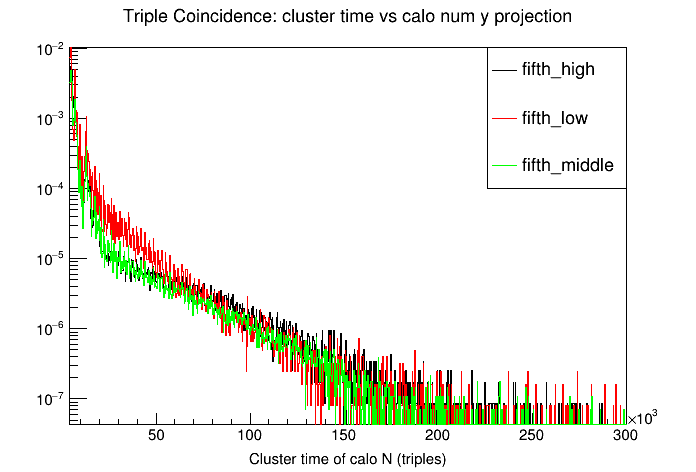

In [33]:
c = r.TCanvas()
leg = r.TLegend(0.7,0.6,0.9,0.9)

for i in range(nDists):
    if(i > 0):
        lossHistograms[i].Draw("hist SAME")
    else:
        lossHistograms[i].Draw("hist")
        #lossHistograms[i].GetYaxis().SetRangeUser(0.000000000001,1)
    lossHistograms[i].SetLineColor(colors[i])
    lossHistograms[i].SetMarkerColor(colors[i])
    leg.AddEntry(lossHistograms[i], distributions[i][0],"l")
leg.Draw("SAME")
c.SetLogy()
c.Draw()

---

### Ok, so now we have the distributions. Lets get to generating some random numbers

---

In [17]:
positionBounds = [-20,40] #mm
timeBounds = [0,300] #mus
positionBins = 100
timeBins = 100

h = r.TH2D("h","Position in FR Distribution vs. Time for Decays",
           positionBins, positionBounds[0], positionBounds[1],
           timeBins, timeBounds[0], timeBounds[1]
           )
hdist = r.TH1D("hdist","Which Distribution was Selected",10,0,10)
np.random.seed(1234)
verbosity = 0
nMuons = 100000
checkWhetherLost = True


for i in range(nMuons):
    #generate a random x,t pair
    if(verbosity > 0):
        print("***************************************")
    x = np.random.uniform(positionBounds[0], positionBounds[1])
    t = np.random.uniform(timeBounds[0], timeBounds[1])
    #get the probability of being in each FR distribution from the functions in funcs
    absoluteProbs = []
    for f in frdists:
        value = f.Eval(x)
        if( value > 0):
            absoluteProbs.append( f.Eval(x) )
        else:
            absoluteProbs.append(0)
    #normalize the probablitites at this point, and choose one
    if(verbosity > 0):
        print(absoluteProbs)
    if(sum(absoluteProbs) <= 0.0):
        continue
    normProbs = [float(i)/sum(absoluteProbs) for i in absoluteProbs]
    if(verbosity > 0):
        print(normProbs)
    choice = np.random.choice(len(normProbs),1,p=normProbs)[0]
    hdist.Fill(choice)

    #get the probability of being lost from this distribution at this time
    pLoss = lossHistograms[choice].Interpolate(t*1000./1.25) #convert microseconds to c.t.
    #pLoss = frdists[choice].Eval(x)
    pLoss *= 1000
    overUnder = np.random.random()
    if(verbosity > 0):
        print(x)
        print(normProbs)
        print(choice)
        print(pLoss, overUnder)

    if((pLoss > overUnder) or  not checkWhetherLost):
        h.Fill(x,t)
        #print("hi")

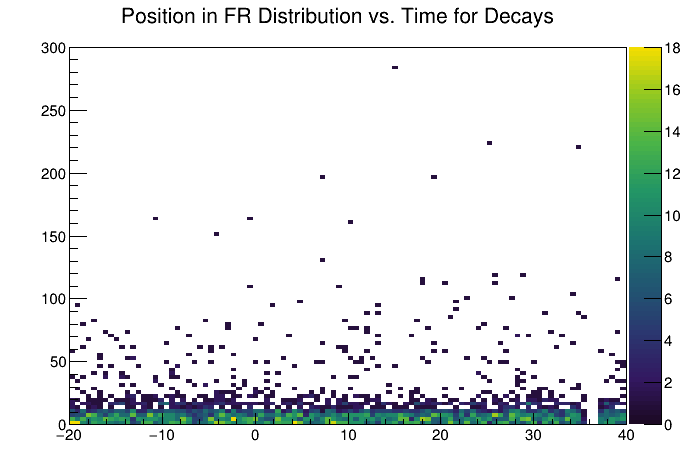

In [19]:
c = r.TCanvas()
h.Draw("colz")
c.Draw()

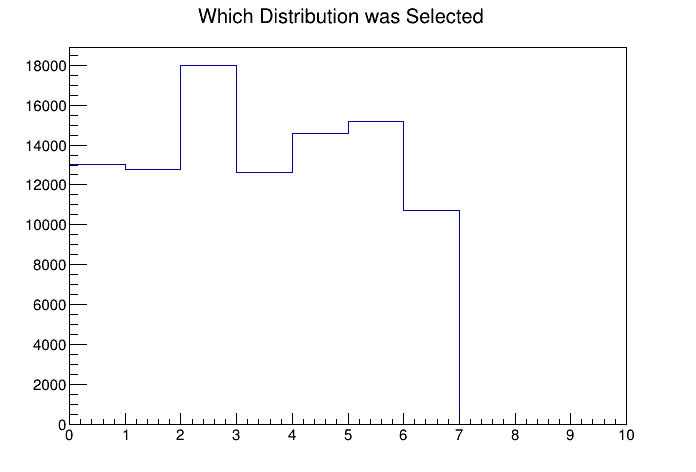

In [18]:
c = r.TCanvas()
hdist.Draw("colz")
c.Draw()

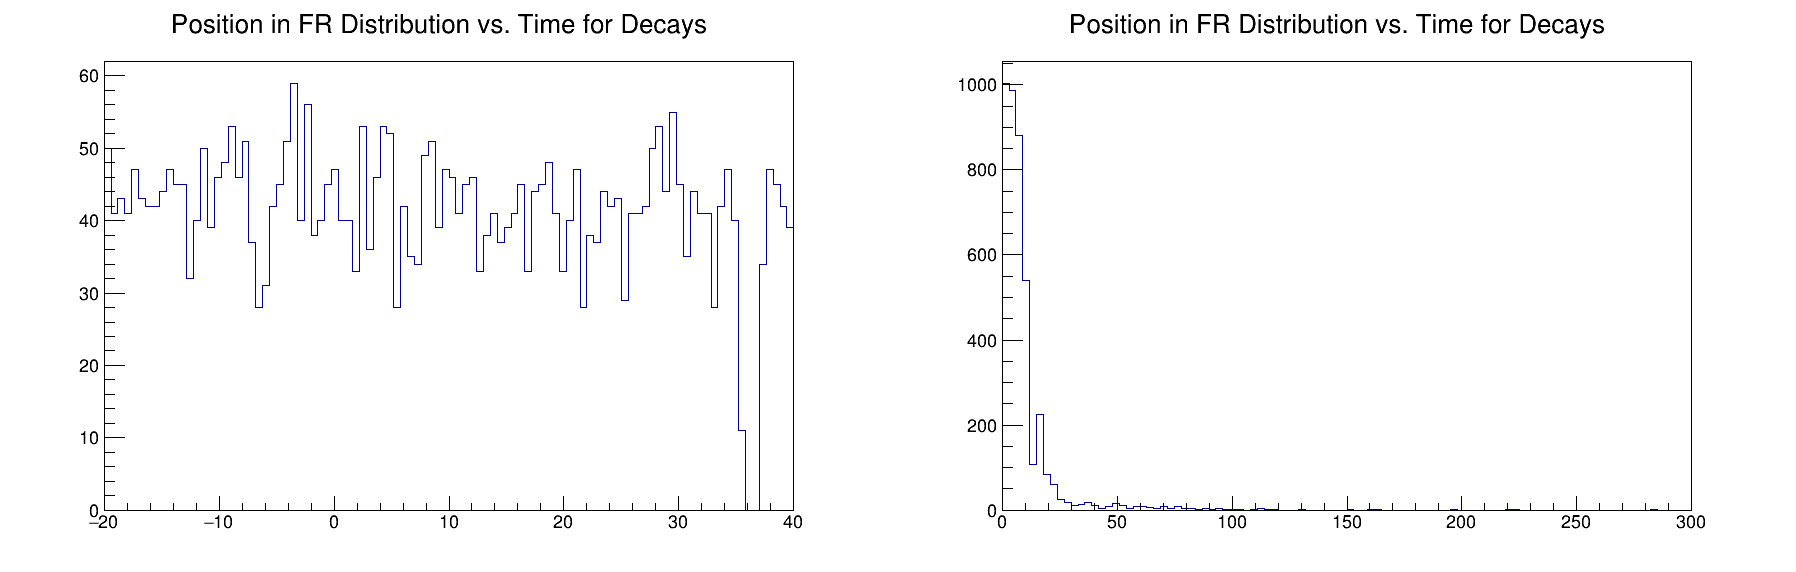

In [20]:
c = r.TCanvas("c","c",1800,600)
c.Divide(2)
c.cd(1)
h.ProjectionX().Draw()
c.cd(2)
h.ProjectionY().Draw()
c.Draw()